Description:  In this notebook we will load saved pre-trained models and compare and evaluate results, and determine next steps.

In [ ]:
import os
import zipfile
import pandas as pd
import shutil
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset as TorchDataset
from transformers import AutoModel, AutoTokenizer, get_scheduler
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = 'drive/MyDrive/Colab Notebooks/data_mining'
filename = 'liar_dataset.zip'

# Define file paths
zip_path = os.path.join(base_dir, filename)
extract_path = os.path.join(base_dir, "liar_dataset")

# Step 2: Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

Dataset extracted to: drive/MyDrive/Colab Notebooks/data_mining/liar_dataset


In [ ]:
# Load training, validation, and test datasets into DataFrames
train_path = os.path.join(extract_path, "train.tsv")
valid_path = os.path.join(extract_path, "valid.tsv")
test_path = os.path.join(extract_path, "test.tsv")

# Define column names based on the dataset structure
columns = [
    "id", "label", "statement", "subject", "speaker", "job",
    "state", "party", "barely_true", "false",
    "half_true", "mostly_true", "pants_on_fire", "context"
]

# Load datasets
train_df = pd.read_csv(train_path, sep='\t', header=None, names=columns)
valid_df = pd.read_csv(valid_path, sep='\t', header=None, names=columns)
test_df = pd.read_csv(test_path, sep='\t', header=None, names=columns)

print("Datasets loaded successfully!")

Datasets loaded successfully!


In [ ]:
# Check the shape of the datasets
print(f"Train Dataset: {train_df.shape}")
print(f"Validation Dataset: {valid_df.shape}")
print(f"Test Dataset: {test_df.shape}")


Train Dataset: (10240, 14)
Validation Dataset: (1284, 14)
Test Dataset: (1267, 14)


In [ ]:
!pip install datasets
# !pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syst

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# plot_confusion_matrix(bert_results[5], bert_results[6], title="Confusion Matrix for BERT")


Next steps:
Picked Hybrid MC Model for further tuning.

Hyperparameter Tuning for Hybrid MC Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset as TorchDataset
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load datasets
train_df = pd.read_csv(train_path, sep='\t', header=None, names=columns)
valid_df = pd.read_csv(valid_path, sep='\t', header=None, names=columns)
test_df = pd.read_csv(test_path, sep='\t', header=None, names=columns)

# Drop rows with missing "speaker" and "party".
train_df.dropna(subset=["speaker", "party"], inplace=True)
valid_df.dropna(subset=["speaker", "party"], inplace=True)
test_df.dropna(subset=["speaker", "party"], inplace=True)

# Map labels to numeric values
label_map = {"pants-fire": 0, "false": 1, "barely-true": 2, "half-true": 3, "mostly-true": 4, "true": 5}
train_df["label"] = train_df["label"].map(label_map)
valid_df["label"] = valid_df["label"].map(label_map)
test_df["label"] = test_df["label"].map(label_map)

# One-hot encode metadata ('speaker' and 'party')
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_metadata = encoder.fit_transform(train_df[["speaker", "party"]])
valid_metadata = encoder.transform(valid_df[["speaker", "party"]])
test_metadata = encoder.transform(test_df[["speaker", "party"]])

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_text(text):
    """Tokenizes input text and returns input_ids and attention_mask."""
    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    return encodings["input_ids"].squeeze(0), encodings["attention_mask"].squeeze(0)

# Tokenize statements
train_tokenized = train_df["statement"].apply(tokenize_text)
valid_tokenized = valid_df["statement"].apply(tokenize_text)
test_tokenized = test_df["statement"].apply(tokenize_text)

# Extract input_ids and attention_mask
train_df["input_ids"], train_df["attention_mask"] = zip(*train_tokenized)
valid_df["input_ids"], valid_df["attention_mask"] = zip(*valid_tokenized)
test_df["input_ids"], test_df["attention_mask"] = zip(*test_tokenized)

# Convert metadata and labels to lists
train_metadata = train_metadata.tolist()
valid_metadata = valid_metadata.tolist()
test_metadata = test_metadata.tolist()

train_labels = train_df["label"].tolist()
valid_labels = valid_df["label"].tolist()
test_labels = test_df["label"].tolist()

# Create dataset class
class HybridDataset(TorchDataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),
            "metadata": torch.tensor(item["metadata"], dtype=torch.float),
            "labels": torch.tensor(item["label"], dtype=torch.long)
        }

# Convert to dataset format
train_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
              for text, mask, meta, label in zip(train_df["input_ids"], train_df["attention_mask"], train_metadata, train_labels)]
valid_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
              for text, mask, meta, label in zip(valid_df["input_ids"], valid_df["attention_mask"], valid_metadata, valid_labels)]
test_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
             for text, mask, meta, label in zip(test_df["input_ids"], test_df["attention_mask"], test_metadata, test_labels)]

# Create PyTorch Dataset
train_dataset = HybridDataset(train_data)
valid_dataset = HybridDataset(valid_data)
test_dataset = HybridDataset(test_data)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Model definition with adjustable parameters
class HybridBERTModelMC(nn.Module):
    def __init__(self, num_metadata_features, num_labels=6, dropout_prob=0.3, metadata_weight=0.2):
        super(HybridBERTModelMC, self).__init__()
        self.bert = AutoModel.from_pretrained("roberta-base")
        self.text_fc = nn.Linear(768, 256)
        self.metadata_fc = nn.Linear(num_metadata_features, 128)
        self.dropout = nn.Dropout(dropout_prob)
        self.metadata_weight = metadata_weight
        self.classifier = nn.Linear(256 + 128, num_labels)

    def forward(self, input_ids, attention_mask, metadata_features):
        text_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_features = torch.relu(self.text_fc(text_output))
        metadata_features = torch.relu(self.metadata_fc(metadata_features))
        combined = torch.cat((self.metadata_weight * text_features, (1 - self.metadata_weight) * metadata_features), dim=1)
        combined = self.dropout(combined)
        return self.classifier(combined)



In [ ]:
# Hyperparameter tuning function
# Store results
results = []

# Hyperparameter tuning function
def train_and_evaluate(dropout_prob, learning_rate, weight_decay, metadata_weight):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = HybridBERTModelMC(num_metadata_features=len(train_metadata[0]), dropout_prob=dropout_prob, metadata_weight=metadata_weight).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*3)

    model.train()
    for epoch in range(3):
        total_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=False)
        for i, batch in enumerate(progress_bar):
            optimizer.zero_grad()
            input_ids, attention_mask, metadata, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["metadata"].to(device), batch["labels"].to(device)
            outputs = model(input_ids, attention_mask, metadata)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()


            if i % 20 == 0:
                progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_dataloader)
        print(f"Dropout: {dropout_prob}, LR: {learning_rate}, Weight Decay: {weight_decay}, Metadata Weight: {metadata_weight}, Loss: {avg_loss:.4f}")

    # Save results
    results.append({
        "dropout": dropout_prob,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "metadata_weight": metadata_weight,
        "train_loss": avg_loss
    })

# Run tuning experiments with overall progress tracking
tuning_combinations = [
    (dropout, lr, wd, mw)
    for dropout in [0.1, 0.3, 0.5]
    for lr in [1e-5, 2e-5, 5e-5]
    for wd in [0.01, 0.05]
    for mw in [0.2, 0.5, 0.8]
]

total_runs = len(tuning_combinations)
# with tqdm(total=total_runs, desc="Hyperparameter Tuning Progress") as tuning_bar:
for dropout_prob, learning_rate, weight_decay, metadata_weight in tuning_combinations:
    train_and_evaluate(dropout_prob, learning_rate, weight_decay, metadata_weight)
    tuning_bar.update(1)

# Convert results to DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(base_dir, "mc_tuning_results.csv"), index=False)
print("Tuning results saved to mc_tuning_results.csv")

# Show best configuration (sorted by lowest loss)
best_params = results_df.sort_values(by="train_loss").head(1)
print("Best Hyperparameter Configuration:")
print(best_params)



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 0/640 [00:00<?, ?it/s]<ipython-input-8-39db6c3a3bc4>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
<ipython-input-8-39db6c3a3bc4>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7535


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7069


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.6663


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7455


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.6984


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.6503


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7470


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.6955


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.6432


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7521


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7096


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.6692


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7382


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.6821


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.6288


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7360


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.6706


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.6061


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7567


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7331


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7142


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7332


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.6630


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.5670


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7385


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.6896


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.6043


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7466


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7060


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.6539


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7410


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.6880


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.6082


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7349


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.6661


Dropout: 0.1, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.5653


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7611


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7562


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7550


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7617


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7579


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7559


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7630


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7596


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7574


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7609


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7562


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7490


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7600


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7572


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7559


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7619


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7585


Dropout: 0.1, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7577


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7580


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7176


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.6784


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7487


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.6980


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.6485


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7373


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.6798


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.6205


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7541


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7091


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.6713


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7416


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.6989


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.6538


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7417


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.6978


Dropout: 0.3, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.6458


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7619


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7558


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7471


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7471


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7034


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.6468


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7389


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.6818


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.5960


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7527


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7208


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.6868


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7634


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7593


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7544


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7370


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.6755


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.5854


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7604


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7571


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7561


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7626


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7589


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7577


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7633


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7591


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7582


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7610


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7572


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7558


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7629


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7589


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7573


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7639


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7604


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.3, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7590


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7594


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7226


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.6900


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7508


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.6995


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.6496


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7474


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.6940


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.6356


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7611


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7198


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.6838


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7481


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7002


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.6510


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7507


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7113


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 1e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.6760


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7598


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7253


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.6836


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7486


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7071


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.6531


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7516


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7045


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.6401


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7557


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7105


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.6609


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7504


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7073


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.6487


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7610


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7310


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 2e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7071


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7622


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7584


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.2, Loss: 1.7587


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7632


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7599


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.5, Loss: 1.7586


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7650


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7599


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.01, Metadata Weight: 0.8, Loss: 1.7576


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7633


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7598


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.2, Loss: 1.7511


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7651


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7617


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.5, Loss: 1.7548


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7656


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7613


Dropout: 0.5, LR: 5e-05, Weight Decay: 0.05, Metadata Weight: 0.8, Loss: 1.7597
Tuning results saved to mc_tuning_results.csv
Best Hyperparameter Configuration:
    dropout  learning_rate  weight_decay  metadata_weight  train_loss
11      0.1        0.00002          0.05              0.8    1.565326


In [ ]:
results_df = pd.DataFrame(results)

# Save results for later analysis
results_df.to_csv(os.path.join(base_dir, "tuning_results.csv"), index=False)
print("Tuning results saved to tuning_results.csv")

# Show best configuration (sorted by lowest loss)
best_params = results_df.sort_values(by="train_loss").head(1)
print("Best Hyperparameter Configuration:")
print(best_params)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize

def evaluate_hybrid(model, dataloader, device):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    num_classes = 6  # Define number of classes

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            metadata = batch["metadata"].to(device)  # Ensure metadata is correctly handled
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask, metadata)

            # Ensure outputs contain logits
            logits = outputs.logits if hasattr(outputs, "logits") else outputs
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()  # Convert logits to probabilities
            preds = np.argmax(probs, axis=1)  # Convert probabilities to class predictions

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)  # Store probabilities for AUC-ROC calculation

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Compute Precision, Recall, F1-score (weighted to handle class imbalance)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

    # One-hot encode labels for multi-class AUC-ROC
    all_labels_one_hot = label_binarize(all_labels, classes=np.arange(num_classes))

    # Compute AUC-ROC
    try:
        auc_roc = roc_auc_score(all_labels_one_hot, np.array(all_probs), multi_class="ovo")
    except ValueError:
        auc_roc = float("nan")  # Handle case where only one class is predicted

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    return accuracy, precision, recall, f1, auc_roc, all_preds, all_labels


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model with correct metadata input size
# num_metadata_features = 10  # ⚠️ Update this based on your dataset's metadata size
num_metadata_features = 2933 #train_metadata.shape[1]  # Gets total one-hot encoded feature count
print(f"Metadata Feature Count: {num_metadata_features}")
hybrid_model = HybridBERTModel(num_metadata_features=num_metadata_features).to(device)

# Load weights
hybrid_model.load_state_dict(torch.load(os.path.join(base_dir,"saved_models", "hybrid_model.pth"), map_location=device))
hybrid_model.eval()  # Set model to evaluation mode


Metadata Feature Count: 2933


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-19-8613ce87f62e>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recom

HybridBERTModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hybrid_results = evaluate_hybrid(hybrid_model, test_dataloader, device)

<ipython-input-17-39db6c3a3bc4>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
<ipython-input-17-39db6c3a3bc4>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),


Accuracy: 0.2660
Precision: 0.2722, Recall: 0.2660, F1-Score: 0.2652
AUC-ROC: 0.6290


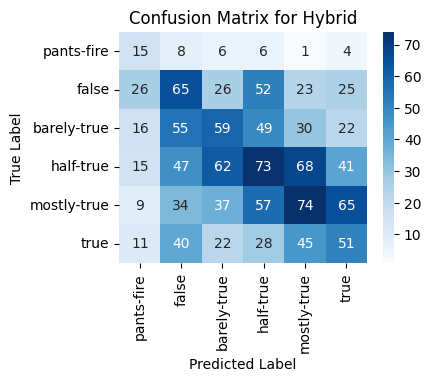

In [ ]:
hybrid_results_dict = {
    "Model": "hybrid",
    "Accuracy": hybrid_results[0],
    "Precision": hybrid_results[1],
    "Recall": hybrid_results[2],
    "F1-Score": hybrid_results[3],
    "AUC-ROC": hybrid_results[4],
}

plot_confusion_matrix(hybrid_results[5], hybrid_results[6], title="Confusion Matrix for Hybrid")

Load Hybrid MC Model

In [ ]:
# Define Hybrid Model with Monte Carlo Dropout
class HybridBERTModelMC(nn.Module):
    def __init__(self, num_metadata_features, num_labels=6, dropout_prob=0.3):
        super(HybridBERTModelMC, self).__init__()
        self.bert = AutoModel.from_pretrained("roberta-base")
        self.text_fc = nn.Linear(768, 256)
        self.metadata_fc = nn.Linear(num_metadata_features, 128)
        self.dropout = nn.Dropout(dropout_prob)  # 🔥 Dropout before classification
        self.classifier = nn.Linear(256 + 128, num_labels)

    def forward(self, input_ids, attention_mask, metadata_features):
        text_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_features = torch.relu(self.text_fc(text_output))
        metadata_features = torch.relu(self.metadata_fc(metadata_features))
        combined = torch.cat((text_features, metadata_features), dim=1)
        combined = self.dropout(combined)  # 🔥 Apply dropout even in inference
        return self.classifier(combined)

In [ ]:
num_metadata_features = 2933 #train_metadata.shape[1]  # Gets total one-hot encoded feature count
print(f"Metadata Feature Count: {num_metadata_features}")
hybridmc_model = HybridBERTModelMC(num_metadata_features=num_metadata_features).to(device)

# Load weights
hybridmc_model.load_state_dict(torch.load(os.path.join(base_dir,"saved_models", "hybrid_mc_dropout_model.pth"), map_location=device))
hybridmc_model.eval()  # Set model to evaluation mode

Metadata Feature Count: 2933


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-34-3125a663d8f0>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

HybridBERTModelMC(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): 

In [ ]:
hybridmc_results = evaluate_hybrid(hybridmc_model, test_dataloader, device)

<ipython-input-17-39db6c3a3bc4>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
<ipython-input-17-39db6c3a3bc4>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),


Accuracy: 0.2755
Precision: 0.2908, Recall: 0.2755, F1-Score: 0.2701
AUC-ROC: 0.6323


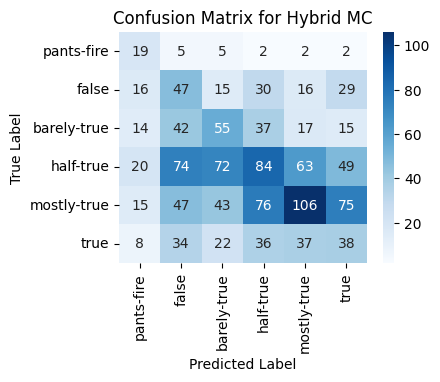

In [ ]:
hybridmc_results_dict = {
    "Model": "hybrid MC",
    "Accuracy": hybridmc_results[0],
    "Precision": hybridmc_results[1],
    "Recall": hybridmc_results[2],
    "F1-Score": hybridmc_results[3],
    "AUC-ROC": hybridmc_results[4],
}

plot_confusion_matrix(hybridmc_results[5], hybridmc_results[6], title="Confusion Matrix for Hybrid MC")

In [ ]:
hybridmc2_model = HybridBERTModelMC(num_metadata_features=num_metadata_features).to(device)

# Load weights
hybridmc2_model.load_state_dict(torch.load(os.path.join(base_dir,"saved_models", "hybrid_mc_dropout_model_r10.pth"), map_location=device))
hybridmc2_model.eval()  # Set model to evaluation mode

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-38-456ba6b88865>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

HybridBERTModelMC(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): 

In [ ]:
hybridmc2_results = evaluate_hybrid(hybridmc2_model, test_dataloader, device)

<ipython-input-17-39db6c3a3bc4>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
<ipython-input-17-39db6c3a3bc4>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),


Accuracy: 0.2565
Precision: 0.2641, Recall: 0.2565, F1-Score: 0.2461
AUC-ROC: 0.6132


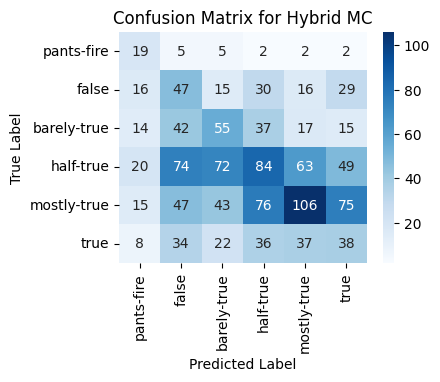

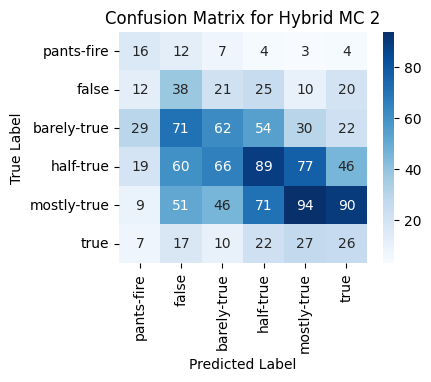

In [ ]:
hybridmc2_results_dict = {
    "Model": "hybrid MC2",
    "Accuracy": hybridmc2_results[0],
    "Precision": hybridmc2_results[1],
    "Recall": hybridmc2_results[2],
    "F1-Score": hybridmc2_results[3],
    "AUC-ROC": hybridmc2_results[4],
}
plot_confusion_matrix(hybridmc_results[5], hybridmc_results[6], title="Confusion Matrix for Hybrid MC")
plot_confusion_matrix(hybridmc2_results[5], hybridmc2_results[6], title="Confusion Matrix for Hybrid MC 2")

In [ ]:
df_results = pd.DataFrame([bert_results_dict, hybrid_results_dict , hybridmc_results_dict , hybridmc2_results_dict])
df_results

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,BERT,0.271507,0.275108,0.271507,0.264224,0.640883
1,hybrid,0.265983,0.272230,0.265983,0.265174,0.628954
2,hybrid MC,0.275454,0.290795,0.275454,0.270126,0.632290
3,hybrid MC2,0.256511,0.264067,0.256511,0.246079,0.613216


In [ ]:
base_dir

'drive/MyDrive/Colab Notebooks/data_mining'

In [ ]:
df_results.to_csv(os.path.join(base_dir, "results.csv"), index=False)

In [ ]:
print(df_results.to_markdown())

|    | Model      |   Accuracy |   Precision |   Recall |   F1-Score |   AUC-ROC |
|---:|:-----------|-----------:|------------:|---------:|-----------:|----------:|
|  0 | BERT       |   0.271507 |    0.275108 | 0.271507 |   0.264224 |  0.640883 |
|  1 | hybrid     |   0.265983 |    0.27223  | 0.265983 |   0.265174 |  0.628954 |
|  2 | hybrid MC  |   0.275454 |    0.290795 | 0.275454 |   0.270126 |  0.63229  |
|  3 | hybrid MC2 |   0.256511 |    0.264067 | 0.256511 |   0.246079 |  0.613216 |
